In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_LPC_Mg.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 49 × 17747
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
BAMs,0,9
Mg_A,4,7
Mg_B,3,8
Mg_trt,3,9
cycl,0,6


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['Mg_A', 'Mg_trt'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (23, 17747)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Pandey et al. 2022': 'Pandey'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-0-0-0-0,(this study),ctrl,Mg_A,1,ctrl_1,LPC_Saline_2,Adams,114835,11.651252,1,Mg_A_LPC_Saline_2
donor_ctrl_2_0-0-0-0-0,(this study),ctrl,Mg_A,2,ctrl_2,LPC_Saline_1,Adams,269101,12.502842,2,Mg_A_LPC_Saline_1
donor_ctrl_4_0-0-0-0-0,Pandey et al. 2022,ctrl,Mg_A,4,ctrl_4,LPC_ctrl_2,Pandey,443698,13.002899,4,Mg_A_LPC_ctrl_2
donor_ctrl_5_0-0-0-0-0,Pandey et al. 2022,ctrl,Mg_A,5,ctrl_5,LPC_ctrl_1,Pandey,1883265,14.448518,5,Mg_A_LPC_ctrl_1
donor_stim_1_0-0-0-0-0,(this study),stim,Mg_A,1,stim_1,LPC_7d_2,Adams,366936,12.812943,1,Mg_A_LPC_7d_2


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

Mg_A_LPC_Saline_2
Mg_A_LPC_Saline_1
Mg_A_LPC_ctrl_2
Mg_A_LPC_ctrl_1
Mg_A_LPC_7d_2
Mg_A_LPC_5d_4
Mg_A_LPC_7d_1
Mg_A_LPC_5d_1
Mg_A_LPC_28d_3
Mg_A_LPC_28d_1
Mg_A_LPC_28d_2
Mg_trt_LPC_Saline_2
Mg_trt_LPC_Saline_1
Mg_trt_LPC_ctrl_1
Mg_trt_LPC_7d_2
Mg_trt_LPC_5d_4
Mg_trt_LPC_7d_1
Mg_trt_LPC_5d_1
Mg_trt_LPC_5d_3
Mg_trt_LPC_28d_3
Mg_trt_LPC_28d_1
Mg_trt_LPC_5d_2
Mg_trt_LPC_28d_2


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                            'Mg_A_LPC_Saline_2',
                            'Mg_A_LPC_Saline_1',
                            'Mg_A_LPC_ctrl_2',
                            'Mg_A_LPC_ctrl_1',
                            'Mg_trt_LPC_7d_2',
                            'Mg_trt_LPC_5d_4',
                            'Mg_trt_LPC_7d_1',
                            'Mg_trt_LPC_5d_1',
                            'Mg_trt_LPC_5d_3',
                            'Mg_trt_LPC_5d_2'                 
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (10, 17747)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
LPC_Saline_2,(this study),ctrl,Mg_A,1,ctrl_1,Adams,114835,11.651252,1,Mg_A_LPC_Saline_2
LPC_Saline_1,(this study),ctrl,Mg_A,2,ctrl_2,Adams,269101,12.502842,2,Mg_A_LPC_Saline_1
LPC_ctrl_2,Pandey et al. 2022,ctrl,Mg_A,4,ctrl_4,Pandey,443698,13.002899,4,Mg_A_LPC_ctrl_2
LPC_ctrl_1,Pandey et al. 2022,ctrl,Mg_A,5,ctrl_5,Pandey,1883265,14.448518,5,Mg_A_LPC_ctrl_1
LPC_7d_2,(this study),stim,Mg_trt,1,stim_1,Adams,1954137,14.485459,1,Mg_trt_LPC_7d_2
LPC_5d_4,Pandey et al. 2022,stim,Mg_trt,11,stim_11,Pandey,69556737,18.057653,11,Mg_trt_LPC_5d_4
LPC_7d_1,(this study),stim,Mg_trt,2,stim_2,Adams,3254539,14.995561,2,Mg_trt_LPC_7d_1
LPC_5d_1,Pandey et al. 2022,stim,Mg_trt,3,stim_3,Pandey,32796382,17.305829,3,Mg_trt_LPC_5d_1
LPC_5d_3,Pandey et al. 2022,stim,Mg_trt,4,stim_4,Pandey,22668898,16.936504,4,Mg_trt_LPC_5d_3
LPC_5d_2,Pandey et al. 2022,stim,Mg_trt,7,stim_7,Pandey,12597375,16.348999,7,Mg_trt_LPC_5d_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[  0   0   2   0  11]
 [  0   6   2   3  12]
 [  0  11   2   2  16]
 [  0  21   3  12  42]
 [  7   5  14  11 135]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

             Group Reps  Batch
LPC_Saline_2  ctrl    1  Adams
LPC_Saline_1  ctrl    2  Adams
LPC_ctrl_2    ctrl    4 Pandey
LPC_ctrl_1    ctrl    5 Pandey
LPC_7d_2      stim    1  Adams
LPC_5d_4      stim   11 Pandey
LPC_7d_1      stim    2  Adams
LPC_5d_1      stim    3 Pandey
LPC_5d_3      stim    4 Pandey
LPC_5d_2      stim    7 Pandey


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 17747    10

ctrl stim 
   4    6 


In [17]:
%%R

cd <- x$samples$group
print(cd)

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
print(design)

 [1] ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim
   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       0      1
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [18]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 10659    10


In [19]:
%%R
# More strict removal of genes, tried group, pub and batch
keep.exprs <- filterByExpr(x, group=batch)
x2 <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(x2)

[1] 10659    10


In [20]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 14.491552  2.573566


In [21]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.6847067 1.4978523 0.9588399 0.9011815 1.2783367 0.7571295 1.2600982
 [8] 0.7831279 0.7228257 0.6642969


In [22]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

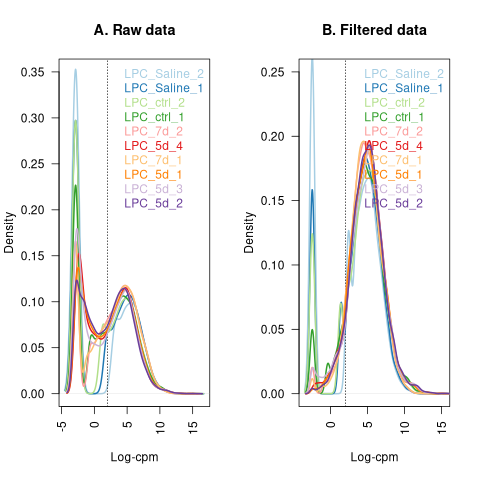

In [23]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

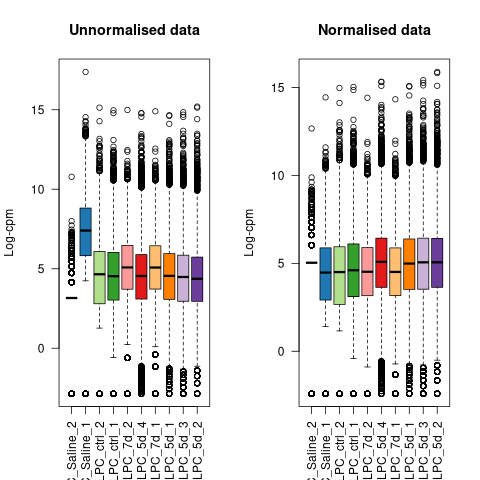

In [24]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [25]:
%%R
cd <- x2$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [26]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

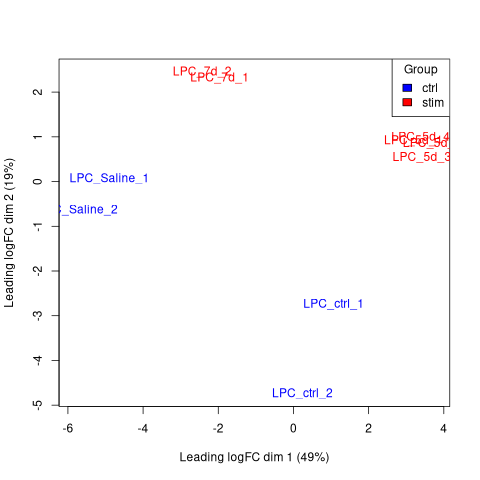

In [27]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

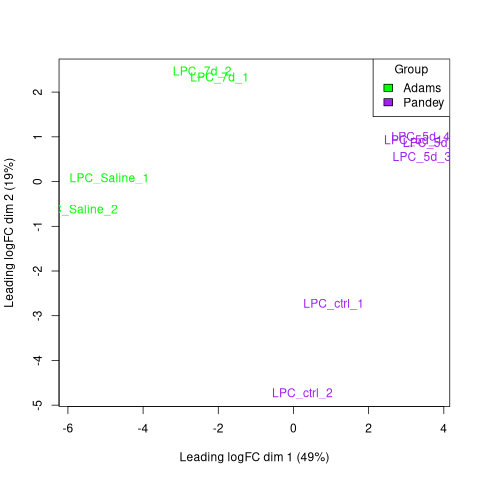

In [28]:
%%R
# Generate a numeric vector from group factors (if not already factor, convert it)
pub_factor <- as.factor(batch)
pub_colors <- as.numeric(pub_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("green", "purple")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[pub_colors])

# Adding a legend for clarity
legend("topright", legend=levels(pub_factor), fill=colors, title="Group")

In [29]:
%%R

x3$samples

             group lib.size norm.factors
LPC_Saline_2  ctrl   113781    1.6847067
LPC_Saline_1  ctrl   266559    1.4978523
LPC_ctrl_2    ctrl   440359    0.9588399
LPC_ctrl_1    ctrl  1871701    0.9011815
LPC_7d_2      stim  1927819    1.2783367
LPC_5d_4      stim 69263421    0.7571295
LPC_7d_1      stim  3219313    1.2600982
LPC_5d_1      stim 32670805    0.7831279
LPC_5d_3      stim 22596963    0.7228257
LPC_5d_2      stim 12544804    0.6642969


In [30]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       0      1
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [31]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [32]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [33]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=batch) 

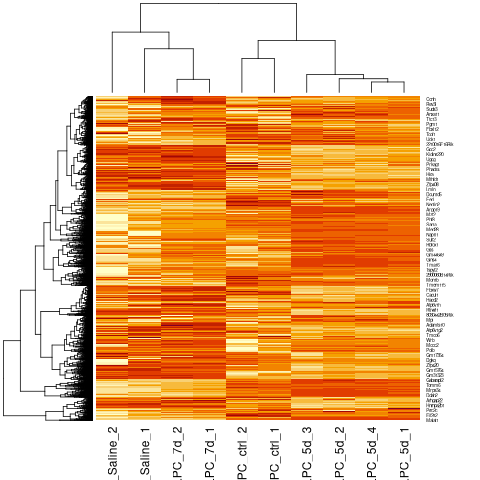

In [34]:
%%R
heatmap(logCPM)

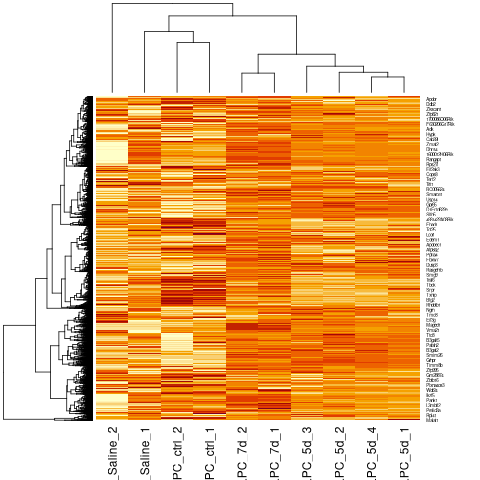

In [35]:
%%R
heatmap(logCPM_no_batch)

# Voom with quality weights

In [36]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       0      1
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [37]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [38]:
%%R
batch

LPC_Saline_2 LPC_Saline_1   LPC_ctrl_2   LPC_ctrl_1     LPC_7d_2     LPC_5d_4 
       Adams        Adams       Pandey       Pandey        Adams       Pandey 
    LPC_7d_1     LPC_5d_1     LPC_5d_3     LPC_5d_2 
       Adams       Pandey       Pandey       Pandey 
Levels: Adams Pandey


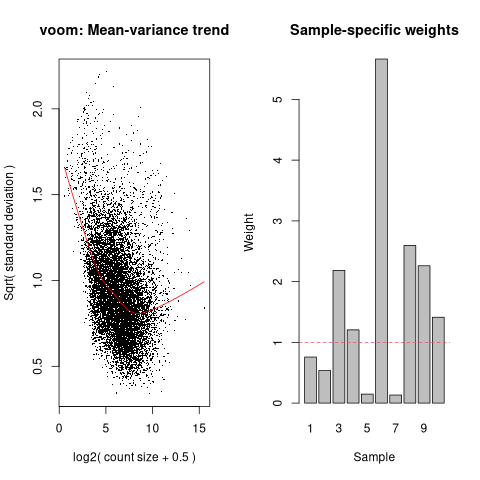

In [39]:
%%R
y <- voomWithQualityWeights(x2$counts, design,plot=TRUE)

In [40]:
%%R
corfit <- duplicateCorrelation(y, design, block=batch)
corfit$consensus.correlation

[1] 0.5105827


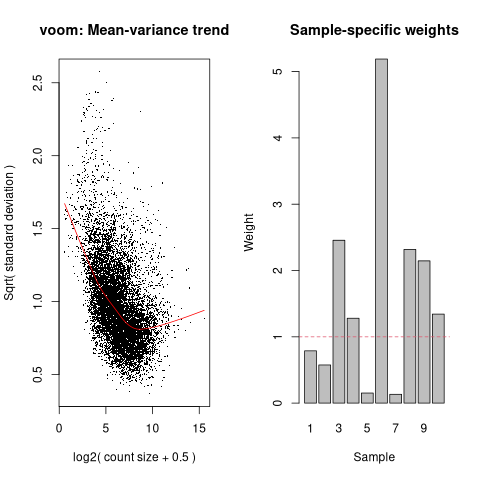

In [41]:
%%R
y2 <- voomWithQualityWeights(x2$counts, design, plot=TRUE, block=batch, correlation=corfit$consensus)

In [42]:
%%R
corfit2 <- duplicateCorrelation(y2,design,block=batch, weights=y2$targets$sample.weights)
corfit2$consensus.correlation

[1] 0.5695263


In [43]:
%%R
fit <- lmFit(y2, design, block=batch, correlation=corfit2$consensus)

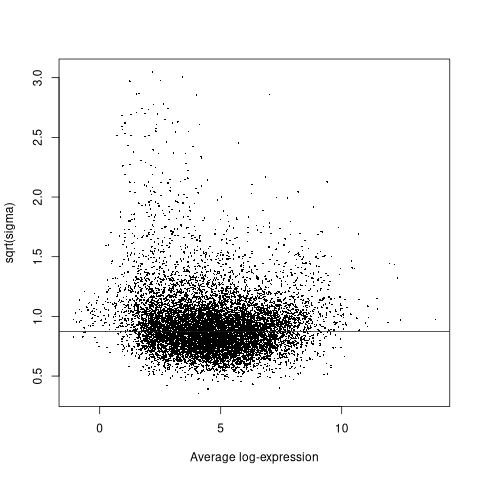

In [44]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [45]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

                  logFC  AveExpr         t      P.Value    adj.P.Val        B
Tspan18       -4.766999 2.874435 -23.33149 2.097323e-11 2.235537e-07 16.03800
Gm10790       -3.805976 6.793027 -19.63986 1.593161e-10 4.709936e-07 14.72040
Cacnb2        -5.049577 6.066487 -19.14628 2.146491e-10 4.709936e-07 14.43728
C430049B03Rik -5.118048 3.014768 -18.87276 2.540001e-10 4.709936e-07 13.93965
Ifitm10       -3.446056 6.819770 -18.65461 2.909768e-10 4.709936e-07 14.12595
Clec4a2       -3.865865 3.014266 -18.62810 2.958524e-10 4.709936e-07 13.85647
Sox4          -3.023597 5.605290 -18.51531 3.176037e-10 4.709936e-07 14.01460
Slc39a12      -5.486076 0.960915 -18.34630 3.534993e-10 4.709936e-07 13.11541
Cdkl4         -4.290580 2.750862 -17.99175 4.438677e-10 5.256873e-07 13.18169
Arid3b        -3.395437 5.273744 -17.49010 6.170096e-10 6.576705e-07 13.32368


In [46]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 4041


In [47]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 3832


In [48]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 3155


In [49]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 914
          logFC  AveExpr        t      P.Value    adj.P.Val          B
Spp1   8.860651 5.917407 5.449827 1.450914e-04 1.351861e-03  1.2395339
Igf1   8.825738 6.014955 8.892892 1.206932e-06 5.229549e-05  5.0755090
Lgals3 8.480823 5.526912 6.428476 3.186311e-05 4.577208e-04  2.5060180
Fabp5  8.431502 5.247558 4.481680 7.410373e-04 4.349513e-03 -0.2185718
Gpnmb  8.328498 5.989371 8.680967 1.556465e-06 6.032859e-05  4.8427407
Apoc1  6.895404 4.318951 4.277647 1.061520e-03 5.691519e-03 -0.5473185


In [50]:
%%R
if ('Apoe' %in% rownames(genes_up_sorted)) {
    print("gene IS in the index of genes_up_sorted")
} else {
    print("gene is NOT in the index of genes_up_sorted")
}

[1] "gene IS in the index of genes_up_sorted"


In [51]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 2241
                  logFC    AveExpr          t      P.Value    adj.P.Val
Gm13269       -8.095767  1.0484632 -12.681419 2.468108e-08 4.445686e-06
2310002F09Rik -8.056605  0.2012922 -16.382137 1.318876e-09 9.818433e-07
Gm28192       -7.105759 -0.1112534 -15.986296 1.750166e-09 9.818433e-07
Chst8         -6.861981  3.7027743  -8.964136 1.109164e-06 4.972603e-05
Gm31243       -6.739560  1.8081010 -14.866604 4.039639e-09 1.537804e-06
Gm46124       -6.547699 -0.6260688  -6.008069 6.011995e-05 7.096551e-04
                      B
Gm13269        9.117104
2310002F09Rik 11.657241
Gm28192       11.003010
Chst8          5.746118
Gm31243       11.211464
Gm46124        2.093258


# Save output- make sure to rename!

In [52]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/LPC_demyel_Mg_A_v_trt_voom_wqw_NEW.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Do results overlap with LR pairs?

In [53]:
import liana as li
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [54]:
DEG_all = pd.read_csv('./files/LPC_demyel_Mg_A_v_trt_voom_wqw_NEW.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(10659, 7)

In [55]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(3155, 7)

In [56]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 44


,ligand,receptor,logFC_ligand,logFC_receptor
17,Spp1,Cd44,8.860651,2.406726
39,Spp1,S1pr1,8.860651,1.307827
18,Spp1,Ptger4,8.860651,2.354261
16,Igf1,Igf2r,8.825738,4.665008
20,Lgals3,Lag3,8.480823,-2.975325
41,Lgals3,Eng,8.480823,-1.992192
33,Apoe,Abca1,5.774016,1.779553
15,Apoe,Lrp5,5.774016,-1.337379
36,Lpl,Cd44,5.725459,2.406726
3,Anxa2,Tlr2,5.231970,1.404108


In [57]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(914, 7)

In [58]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 16


,ligand,receptor,logFC_ligand,logFC_receptor
6,Spp1,Ptger4,8.860651,2.354261
5,Spp1,Cd44,8.860651,2.406726
15,Spp1,S1pr1,8.860651,1.307827
4,Igf1,Igf2r,8.825738,4.665008
11,Apoe,Abca1,5.774016,1.779553
13,Lpl,Cd44,5.725459,2.406726
1,Anxa2,Tlr2,5.231970,1.404108
10,Vim,Cd44,4.430038,2.406726
2,Fn1,Cd44,4.392928,2.406726
3,Lama3,Cd44,3.016781,2.406726


In [59]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('LR_LPC_de_trt_NEW.csv', sep='\t', index=False)